# <center> AI Preventive Maintenance Classifier Project <center>

Author: Matheus Vilar Mota Santos 

Date: 12/07/2024

Contact: vilarmms@gmail.com

Likedin: https://www.linkedin.com/in/matheus-vilar-03708292/

## Introduction

The proposed problem involves developing a supervised classification AI solution to minimize maintenance expenses for a client in the logistic business. The main goal is to automate decisions on preventive vehicle repairs of the client's fleet to mitigate the high costs associated with late system failure detection.

The company maintains an average number of trucks in its fleet to deliver across the country, but in the last three years it has been noticing a large increase in the expenses related to the maintenance of the air system of its vehicles, even though it has been keeping the size of its fleet relatively constant. The maintenance cost of this specific system is shown below. The blue data comprises the historical data provided by the client, and the red data is a projection of the upcoming years expenses considering the same trend continues. 

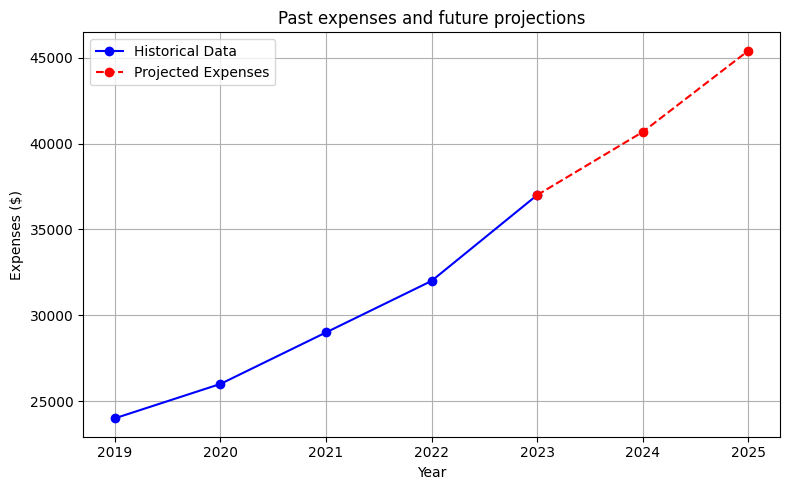

Projected cost on 2025: $45407


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data
years = np.array([2019, 2020, 2021, 2022, 2023])
costs = np.array([24000, 26000, 29000, 32000, 37000]) 

def exponential_func(x, a, b):
    return a * np.exp(b * (x - 2016))

# Fit the exponential model
params_exp, _ = curve_fit(exponential_func, years, costs)

# Extract the fitted parameters
a_exp, b_exp = params_exp

# Project costs for 2021 and 2022
years_proj = np.array([2023, 2024, 2025])
costs_proj_exp = exponential_func(years_proj, a_exp, b_exp)
costs_proj_exp[0] = costs[-1]

# Plotting historical data
plt.figure(figsize=(8, 5))
plt.plot(years, costs, marker='o', linestyle='-', color='b', label='Historical Data')

# Plotting projected expenses
plt.plot(years_proj, costs_proj_exp, marker='o', linestyle='--', color='r', label='Projected Expenses')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Expenses ($)')
plt.title('Past expenses and future projections')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Projected cost on {years_proj[-1]:.0f}: ${costs_proj_exp[-1]:.0f}')

To reduce projected costs, the client seeks an AI solution to analyze vehicle condition data and make better decisions regarding preventive vehicle repairs.

The client has provided data from previous and current years, which includes encoded features representing vehicle conditions and the necessity of repairs in each case. Consequently, this problem falls under the category of classification AI models. Three different solutions are proposed and evaluated for their performance:

- Logistic Regression (implemented using Scikit-Learn)
- Decision Tree (implemented using CatBoost)
- Random Forest (implemented using CatBoost)

## Exploratory Data Analysis


This section delves into the dataset, addressing missing values originating from the digitalization of the client's file. This step is crucial to ensure the machine learning models are well-trained and can generalize effectively to future data. Initially, we gather general information about the dataset and replace null entries with 'NaN' values for improved handling

In [36]:
# Loading dataframe
df_raw_past = pd.read_csv('air_system_previous_years.csv', sep = ',',engine='pyarrow',na_values=['na'])

print(df_raw_past.info(verbose=True,max_cols = df_raw_past.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #    Column  Non-Null Count  Dtype  
---   ------  --------------  -----  
 0    class   60000 non-null  object 
 1    aa_000  60000 non-null  int64  
 2    ab_000  13671 non-null  float64
 3    ac_000  56665 non-null  float64
 4    ad_000  45139 non-null  float64
 5    ae_000  57500 non-null  float64
 6    af_000  57500 non-null  float64
 7    ag_000  59329 non-null  float64
 8    ag_001  59329 non-null  float64
 9    ag_002  59329 non-null  float64
 10   ag_003  59329 non-null  float64
 11   ag_004  59329 non-null  float64
 12   ag_005  59329 non-null  float64
 13   ag_006  59329 non-null  float64
 14   ag_007  59329 non-null  float64
 15   ag_008  59329 non-null  float64
 16   ag_009  59329 non-null  float64
 17   ah_000  59355 non-null  float64
 18   ai_000  59371 non-null  float64
 19   aj_000  59371 non-null  float64
 20   ak_000  55600 non-null  float64
 21   al_000  59

Important information, such as the count of null entries per feature, is provided in the previous snippet. Additionally, we can visualize the initial data entries to familiarize ourselves with the DataFrame.

In [37]:
display(df_raw_past.head())

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


An important aspect of Exploratory Data Analysis is deciding whether to address outliers, as they might affect the performance of machine learning models. However, effective outlier treatment requires detailed feature information. To avoid discarding potentially relevant data that could impact model performance, outlier treatment is not performed in this analysis.

Before proceeding with cleaning the dataset of missing values, it is advisable to test each feature for normal distribution to determine appropriate data cleaning methods for this particular case.

In [38]:
from scipy import stats

# Define a function to perform the KS test for normality
def ks_test_normality(feature_data):

    # Drop NaN values
    feature_data = feature_data.dropna()

    # Calculating statistical metrics
    mean = np.mean(feature_data)
    std = np.std(feature_data)

    # Performing the test
    ks_statistic, p_value = stats.kstest(feature_data, 'norm', args=(mean, std))

    return ks_statistic, p_value

# Apply the KS test to each feature
results = {}
alpha = 0.05  # significance level

# Looping all features except the first column
for column in df_raw_past.iloc[:, 1:].columns:
    ks_stat, p_val = ks_test_normality(df_raw_past[column])
    results[column] = {
        'KS Statistic': ks_stat,
        'P-Value': p_val,
        'Normal': p_val <= alpha
    }

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)
false_count = sum(1 for entry in results.values() if not entry['Normal'])
print('Number of non-normal distributions',false_count)

/home/vilarmms/Teste/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2110: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


       KS Statistic P-Value Normal
aa_000     0.341633     0.0   True
ab_000     0.418783     0.0   True
ac_000     0.505709     0.0   True
ad_000      0.50119     0.0   True
ae_000     0.488317     0.0   True
...             ...     ...    ...
ee_007      0.42059     0.0   True
ee_008     0.378802     0.0   True
ee_009     0.429864     0.0   True
ef_000     0.503819     0.0   True
eg_000     0.501178     0.0   True

[170 rows x 3 columns]
Number of non-normal distributions 1



The next step involves replacing 'NaN' entries with valid numbers, which necessitates understanding the meaning of each feature for informed decision-making. Since detailed feature information is lacking and most features exhibit a normal distribution (169 out of 170), the adopted methodology for handling 'NaN' values is to impute them with the mean value of the respective feature.

In [39]:
# Replace NaN values with feature mean
df_clean_past = df_raw_past.fillna(df_raw_past.mean(numeric_only = True))
print("Total number of NaN after mean substituion procedure:", df_clean_past.isna().sum().sum())

Total number of NaN after mean substituion procedure: 0


Given the large number of features, it is prudent to identify relevant features for the classification model and remove those with high correlations to mitigate multicollinearity.

In [40]:
# Breaking dataframe into trainin set X and target y
y_past = df_clean_past.iloc[:,0]
X_past = df_clean_past.iloc[:,1:]

# Compute the correlation matrix
correlation_matrix = X_past.corr().abs()

# Create a boolean mask to identify features with high correlation
threshold = 0.5
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop highly correlated features from the DataFrame
X_past_short = X_past.drop(columns = to_drop)

# Features dropped
print(f"Number of dropped features due to high correlation: {len(to_drop)}")


Number of dropped features due to high correlation: 115


The same procedure is applied to preprocess the data from the current year (provided in the file 'air_system_present.csv' by the client), including the removal of the same features for consistency.

In [41]:
df_raw_present = pd.read_csv('air_system_previous_years.csv', sep = ',', na_values=['na'])
df_clean_present = df_raw_present.fillna(df_raw_present.mean(numeric_only = True))
y_present = df_clean_present.iloc[:,0]
X_present_clean = df_clean_present.iloc[:,1:]
X_present_short = X_present_clean.drop(columns = to_drop)

Both the data from this year and the previous year are standardized to enhance the performance of the AI models.

In [42]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_past_short_hom = scaler.fit_transform(X_past_short)
X_present_short_hom = scaler.transform(X_present_short)

As a result, the Exploratory Data Analysis is concluded, and the model is now prepared for training To streamline the model fitting process, let's encode the target classes such that positive cases are assigned the label 1, and negative cases are assigned the label 0.

In [43]:
# Replace 'pos' with 1 and 'neg' with 0
y_past = np.where(y_past == 'pos', 1, 0)
y_present = np.where(y_present == 'pos', 1, 0)

print(f'Positive classes in:\nPast year: {y_past.sum()}\nCUrrent year: {y_present.sum()}')

Positive classes in:
Past year: 1000
CUrrent year: 1000


Next, the dataframe is split into a training and a test set. Before proceeding, it is essential to assess whether the target class is imbalanced. If imbalance is detected, both the training and test sets must include sufficient positive cases to effectively train and validate the model.

In [44]:
print(f"Share of positive target training classes: {round(100 * y_past.sum()/len(y_past),2)}%")

Share of positive target training classes: 1.67%


It is evident that the dataset is imbalanced, with only 1.67% of the target class being positive. Therefore, the dataset is split to ensure that both the training and test sets contain data points with positive target classes.

In [45]:
from sklearn.model_selection import train_test_split

# Spliting the dataframe in training and test sets
X_Reg_train, X_Reg_test, y_train, y_test = train_test_split(X_past_short_hom, y_past, test_size = 0.3, random_state = 42, stratify = y_past)

print(f"Share of positive classes in:\nTraining set: {round(100*y_train.sum()/len(y_train),2)}%")
print(f"Test set: {round(100*y_test.sum()/len(y_test),2)}%")


Share of positive classes in:
Training set: 1.67%
Test set: 1.67%


### - Expenses minimisation


Let's now focus on addressing the client's needs. The models proposed in the next section aim to reduce vehicle maintenance expenses. Our objective is to train the models to minimize the client's costs, taking into account the expenses associated with failure detection as follows:

- Vehicle inspection detects an error (true positive): $25
- Vehicle inspection does not detect an error (false positive): $10
- Vehicle damaged and not sent for repair (false negative): $500

Therefore, there is a trade-off between identifying unnecessary vehicle inspections (false positives) and not inspecting damaged vehicles (false negatives). As such, the following cost function is employed to assist the AI in making decisions to reduce expenses.

In [46]:
# Define function to calculate cost based on confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def calculate_cost(y_true, y_pred):

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Weights associated to expenses
    w_FN = 500
    w_TP = 25
    w_FP = 10
    # Cost evaluation
    cost = cm[0, 1]*w_FP + cm[1, 0]* w_FN + cm[1, 1]* w_TP
    return cost

Exploratory Data Analysis and data manipulation have been completed in this section, and we are now ready to proceed with model training.

## Model (1) - Logistic Regression

This section uses the Scikit-Learn library to train a logistic regression model. To improve feature selection, regularization techniques (L1 and L2) are applied, and their hyperparameters are optimized. GridSearchCV is used to identify the optimal penalty hyperparameter. Additionally, an algorithm is implemented to determine an optimized decision boundary.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, log_loss
from sklearn.datasets import make_classification

# Define the Logistic Regression model with Reg (L1) regularization
RegressionModel = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, class_weight='balanced')

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [10, 100, 1000, 5000],  # Regularization parameter
    'penalty': ['l1', 'l2'] # Penalty definition
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=RegressionModel,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=3,
    verbose=1,
    n_jobs=-1
)
# Fit GridSearchCV on the training data
grid_search.fit(X_Reg_train, y_train)

# Evaluate the best model and predict on test set
best_Regression = grid_search.best_estimator_
print(best_Regression)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
LogisticRegression(C=100, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')


As indicated in the text above, the optimal hyperparameters for the proposed Logistic Regression model include C=10,000 and the Lasso (L1) regularization method.

## Model (2) - Decision tree

The proposed problem is addressed here using a Decision Tree algorithm implemented with the CatBoost library to enhance efficiency and AI performance. CatBoost includes a built-in pre-processor that handles missing values and manages heterogeneous data, potentially offering greater efficiency compared to the Exploratory Data Analysis procedure implemented in this project. Therefore, we utilize the raw data to train the model.

In [48]:
X_past_raw = df_clean_past.iloc[:,1:]
y_past_raw = df_clean_past.iloc[:,0]
X_present_raw = df_clean_present.iloc[:,1:]
y_present_raw = df_clean_present.iloc[:,0]
y_past_raw = np.where(y_past_raw == 'pos', 1, 0)
y_present_raw = np.where(y_present_raw == 'pos', 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X_past_raw, y_past_raw, test_size = 0.3, random_state = 42, stratify = y_past)


In [49]:
from catboost import CatBoostClassifier, Pool

# Define the CatBoostClassifier model with adjusted parameters
DecisionTreeModel = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=9,
    loss_function='Logloss',
    eval_metric='Logloss',
    random_seed=42,
    use_best_model=True,
    logging_level='Verbose'
)

# Create train and eval pools
train_pool = Pool(X_train, y_train)
eval_pool = Pool(X_test, y_test)

# Fit the model with early stopping
DecisionTreeModel.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=50, verbose=100)

0:	learn: 0.4164129	test: 0.4179877	best: 0.4179877 (0)	total: 354ms	remaining: 5m 53s
100:	learn: 0.0076234	test: 0.0178807	best: 0.0178807 (100)	total: 15.2s	remaining: 2m 15s
200:	learn: 0.0039101	test: 0.0170118	best: 0.0169715 (197)	total: 29.1s	remaining: 1m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01683229474
bestIteration = 246

Shrink model to first 247 iterations.


## Model (3) - Random Forest

A Random Forest classifier is suggested below to model the proposed problem, also using Catboost library.

In [50]:
RandomForestModel = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    verbose=100,
    loss_function='Logloss',
    eval_metric='Logloss',
    random_seed=42,
    random_strength=1,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    rsm=0.8
)

train_pool = Pool(X_train, y_train)
eval_pool = Pool(X_test, y_test)

# Training model
RandomForestModel.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=50)

0:	learn: 0.4448784	test: 0.4454954	best: 0.4454954 (0)	total: 216ms	remaining: 3m 36s
100:	learn: 0.0061965	test: 0.0179545	best: 0.0179545 (100)	total: 18.9s	remaining: 2m 48s
200:	learn: 0.0030199	test: 0.0171711	best: 0.0171158 (186)	total: 37.7s	remaining: 2m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01711421592
bestIteration = 223

Shrink model to first 224 iterations.


## Model selection

The developed machine learning models determine whether a vehicle requires repair by computing probabilities learned from the training data. To classify into positive or negative classes, the AI models compare the predicted probability to a decision boundary, also known as the "threshold". By default, machine learning models adopt a threshold of 50%, where higher predicted probabilities are assigned to positive classes. However, the default threshold value may not be optimal for the current project due to the significant negative impact of false negatives (incorrect predictions of vehicles requiring repair). Therefore, smaller threshold values might be considered to minimize cost expenses.

To optimize the threshold, threshold values are optmized according to the best F-beta, a data science metric that allows flexibility in weighting either recall or precision. Given that false negatives cost 50 times more than false positives, an appropriate beta value reflecting this consideration is selected. After several trial and error simulations, the beta value resulting in lower expenses was determined to be 4 for the Decision Tree and Random Forest models, and 7 to the Logistic Regression model.

In [51]:
from sklearn.metrics import precision_recall_curve

# Function to search optimal threshold values for best decision boundary decisions
def find_optimal_threshold(y_true, y_prob, beta):

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Calculate F-beta score
    fbeta_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    
    # Find the threshold that maximizes F2 score
    optimal_threshold = thresholds[np.argmax(fbeta_score)]
    
    return optimal_threshold

# Function to apply decision boundary decisions
def Apply_classification(y_prob, threshold):
    y_pred = np.where(y_prob >= threshold, True, False)
    return y_pred

The following figures depict the confusion matrix of each model based on the data from the present year.

In [52]:
from sklearn.metrics import classification_report

# Last year probabilities
y_past_prob_Reg = best_Regression.predict_proba(X_Reg_test)[:, 1]
y_past_prob_DT = DecisionTreeModel.predict_proba(X_test)[:, 1]
y_past_prob_RF = RandomForestModel.predict_proba(X_test)[:, 1]

# Optimal threshold based on last year validation test set
beta_Reg = 7
optimal_threshold_Reg = find_optimal_threshold(y_test, y_past_prob_Reg, beta_Reg)
beta_DT = 4
optimal_threshold_DT = find_optimal_threshold(y_test, y_past_prob_DT, beta_DT)
beta_RF = 4
optimal_threshold_RF = find_optimal_threshold(y_test, y_past_prob_RF, beta_RF)

# Predicting current year
y_present_prob_Reg = best_Regression.predict_proba(X_present_short_hom)[:, 1]
y_present_prob_DT = DecisionTreeModel.predict_proba(X_present_clean)[:, 1]
y_present_prob_RF = RandomForestModel.predict_proba(X_present_clean)[:, 1]

# Classification prediction
y_present_pred_Reg = Apply_classification(y_present_prob_Reg, optimal_threshold_Reg)
y_present_pred_DT = Apply_classification(y_present_prob_DT, optimal_threshold_DT)
y_present_pred_RF = Apply_classification(y_present_prob_RF, optimal_threshold_RF)

# Costs
cost_val_Reg = calculate_cost(y_present, y_present_pred_Reg)
cost_val_DT = calculate_cost(y_present, y_present_pred_DT)
cost_val_RF = calculate_cost(y_present, y_present_pred_RF)

print(f'Regression: optimized threshold: {optimal_threshold_Reg:.2f} - Cost: {cost_val_Reg:.0f}')
print(f'Decision Tree: optimized threshold: {optimal_threshold_DT:.2f} - Cost: {cost_val_DT:.0f}')
print(f'Random Forest: optimized threshold: {optimal_threshold_RF:.2f} - Cost: {cost_val_RF:.0f}')


Regression: optimized threshold: 0.23 - Cost: 78560
Decision Tree: optimized threshold: 0.06 - Cost: 39195
Random Forest: optimized threshold: 0.04 - Cost: 38865


As such, the best thresholds values fall below the default value adopted by the AI models developed here. Further insight on model performance can be gained by analysing comparing each model confusion matrices.

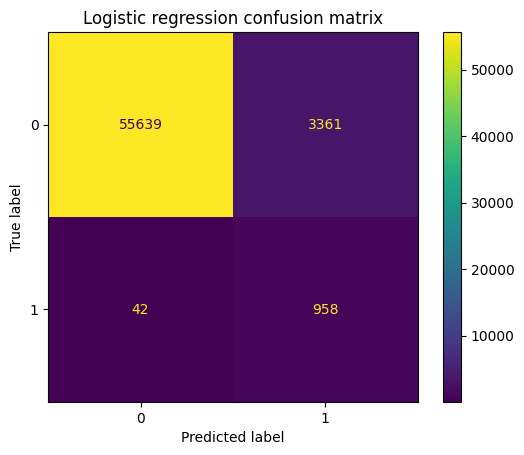

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     59000
           1       0.22      0.96      0.36      1000

    accuracy                           0.94     60000
   macro avg       0.61      0.95      0.67     60000
weighted avg       0.99      0.94      0.96     60000



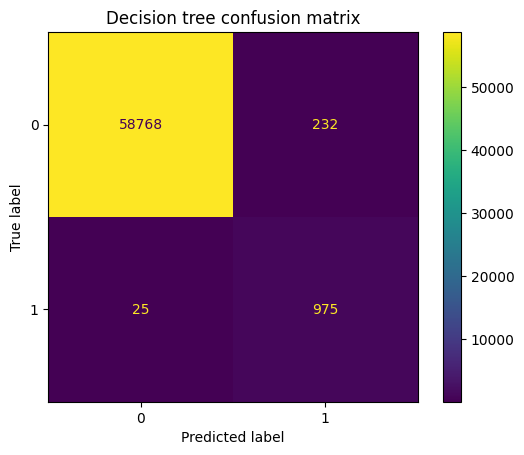

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       0.81      0.97      0.88      1000

    accuracy                           1.00     60000
   macro avg       0.90      0.99      0.94     60000
weighted avg       1.00      1.00      1.00     60000



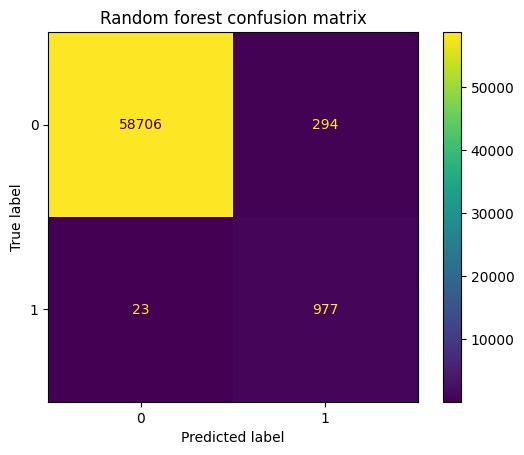

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       0.77      0.98      0.86      1000

    accuracy                           0.99     60000
   macro avg       0.88      0.99      0.93     60000
weighted avg       1.00      0.99      1.00     60000



In [53]:
# Confusion matrices
cm_val_Reg = confusion_matrix(y_present, y_present_pred_Reg)
cm_val_DT = confusion_matrix(y_present, y_present_pred_DT)
cm_val_RF= confusion_matrix(y_present, y_present_pred_RF)

# Logistic regression confusion matrices display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_Reg,display_labels=best_Regression.classes_)
disp.plot()
plt.title("Logistic regression confusion matrix")
plt.show()
print("Classification Report:")
print(classification_report(y_present,y_present_pred_Reg))


# Decision tree confusion matrices display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_DT,display_labels=DecisionTreeModel.classes_)
disp.plot()
plt.title("Decision tree confusion matrix")
plt.show()
print("Classification Report:")
print(classification_report(y_present,y_present_pred_DT))


# Random Forest confusion matrices display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_RF,display_labels=RandomForestModel.classes_)
disp.plot()
plt.title("Random forest confusion matrix")
plt.show()
print("Classification Report:")
print(classification_report(y_present,y_present_pred_RF))



Notably, the confusion matrices and classification reports of the Decision Tree and Random Forest models suggest better performance, with the latter slightly outperforming the former and being more robust and stable. However, we do not have enough evidence to definitively confirm that the Random Forest model is superior. It is possible that future data predictions by the Decision Tree model could outperform the other models. Therefore, a statistical A/B hypothesis test should be conducted to gain further insights into which model performs the best, but such analysis is beyond the scope of this project.

## Cost saving analysis

Cost expenses on vehicle maintenance have been provided by the client up to the year 2023. Note that the model is trained on 2023 data (past year) and benchmarked against data from 2024 (present year). Let's determine how much each model could potentially reduce the current year expenses and compare them with the projected cost to 2025 of $45,407 (given in the introduction), noting the baseline for a perfect machine learning algorithm. These savings are also compared to the baseline scenario where all damaged vehicles are correctly identified.

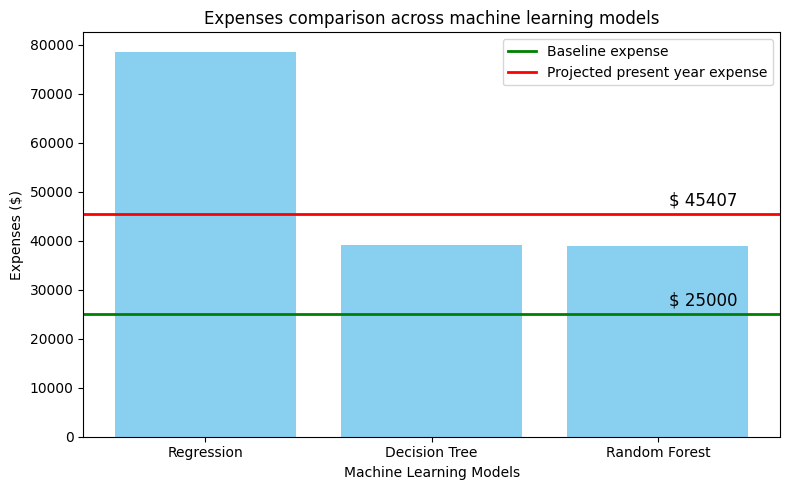

In [54]:
# Define baseline and present year expenses
baseline_expense = 25000
present_year_expense = costs_proj_exp[-1]

# Machine learning models and their corresponding costs
models = ['Regression', 'Decision Tree', 'Random Forest']
costs = [cost_val_Reg, cost_val_DT, cost_val_RF]

# Plotting the bar plot
plt.figure(figsize=(8, 5))

# Plot bars for the models with the chosen color
plt.bar(models, costs, color='#89CFF0')

# Plot horizontal lines for baseline and present year expenses with thicker lines
plt.axhline(y=baseline_expense, color='green', linestyle='-', linewidth=2, label=f'Baseline expense')
plt.axhline(y=present_year_expense, color='red', linestyle='-', linewidth=2, label=f'Projected present year expense')

# Add text annotations for the values of horizontal lines
plt.text(2.2, baseline_expense + 1000, f'$ {baseline_expense}', fontsize=12, ha='center', va='bottom', color='black')
plt.text(2.2, present_year_expense + 1000, f'$ {present_year_expense:.0f}', fontsize=12, ha='center', va='bottom', color='black')

# Add labels and title
plt.xlabel('Machine Learning Models')
plt.ylabel('Expenses ($)')
plt.title('Expenses comparison across machine learning models')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


Considering the current year expense is projected to be $45,407, the Decision Tree and Random Forest models successfully saved costs by correctly identifying the vehicles that need preventive repair. Below, we can see how much the AI models could potentially save under the projected year expenses.

/tmp/ipykernel_36171/3100714979.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


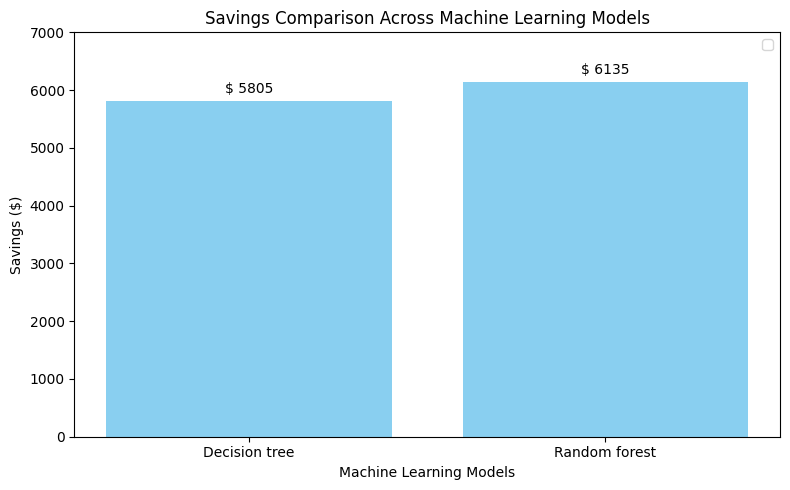

In [55]:
# Machine learning models and their corresponding costs
models = ['Decision tree', 'Random forest']
savings = [(45000 - cost_val_DT), (45000 - cost_val_RF)]

# Plotting the bar plot
plt.figure(figsize=(8, 5))

# Bars for the models with the chosen color
bars  = plt.bar(models, savings, color='#89CFF0')

# Labels and title
plt.xlabel('Machine Learning Models')
plt.ylabel('Savings ($)')
plt.title('Savings Comparison Across Machine Learning Models')

# Add legend
plt.legend()

# y-axis limits
plt.ylim(0, 7000)

# Add values on top of each bar
for bar, saving in zip(bars, savings):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, f'$ {saving:.0f}', ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

As illustrated in the figure above, the Random Forest model potentially saves the most, making it a strong candidate to reduce expenses for the proposed project.

It is important to highlight that the regression model may require further tuning to improve its predictions. Its underperformance can be partly explained by the limited exploratory data analysis performed in this project compared to the built-in data handling capabilities of the CatBoost model. Additionally, the limited resources on the computer performing these tests may also contribute to the regression model's underperformance.

## Feature engineering

This section offers insight into the most relevant features to be considered in the model, illustrated in the next figure.

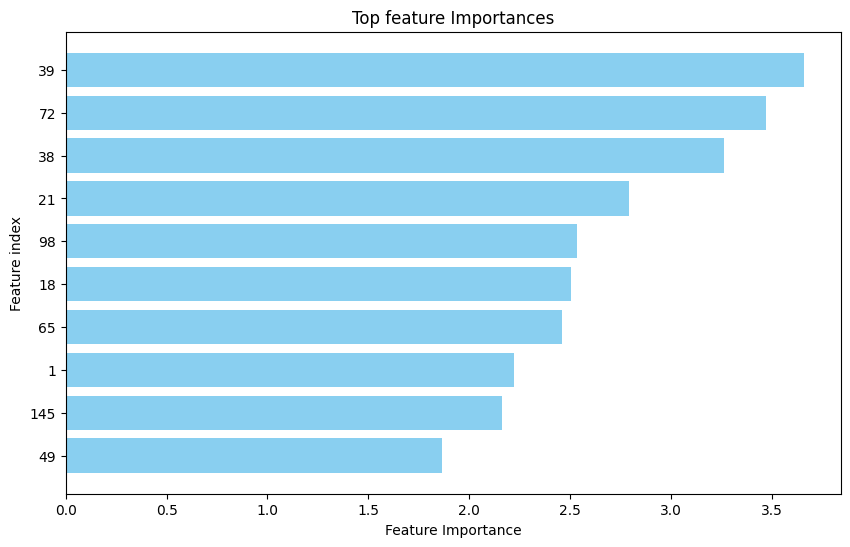

In [56]:
## Get feature importance
feature_importances = RandomForestModel.get_feature_importance()
feature_names = [f'{i}' for i in range(1, X_present_clean.shape[1] + 1)]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and select the top 10 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='#89CFF0')
plt.xlabel('Feature Importance')
plt.ylabel('Feature index')
plt.title('Top feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

The most important features are given in the figure above, an information of great value to the client to reduce costs further by monitoring and optmizing procedures.

## Conclusion

Machine learning solutions have been provided in this document to reduce expenses associated with vehicle repair detection for client in the logistic sector. Three different models have been developed: a Logistic Regression model, a Decision Tree model, and a Random Forest model. Out of these three, the Decision Tree and Random Forest models have successfully accomplished their objectives (assuming future expense projections are valid), saving $5,805 (approximately 12.8% cost reduction) and $6,135 (approximately 13.51% cost reduction), respectively.

All the developed models can be further tuned to reduce client expenses. However, the limited time and computational resources available for processing these models do not contribute to this purpose. Further tuning can be achieved by, for example, increasing the depth of the decision trees, optimizing the learning rate and threshold of decision boundaries, dropping less features detected with high correlation (only for the Logistic Regression model), and testing different evaluation metrics.

Finally, a feature engineering procedure was employed, and the ten most relevant features have been provided to the client for monitoring purposes and potentially optimizing procedures to further reduce repair costs.